In [1]:
import pandas as pd
import json
from diskcache import Cache
from matplotlib import pyplot as plt
import psycopg2
import time
import numpy as np

In [2]:
db_user = "postgres"
db_password = "admin"
db_host = "localhost"
db_port = 5432
db_name_1 = "tpch"
db_name_2 = "tpch_columnar"

conn1 = psycopg2.connect(f"dbname='{db_name_1}' user='{db_user}' host='{db_host}' password='{db_password}'")
conn2 = psycopg2.connect(f"dbname='{db_name_2}' user='{db_user}' host='{db_host}' password='{db_password}'")
print("OK")

OK


In [3]:
count_query_template = """
SELECT COUNT(*) FROM lineitem
where l_shipdate <= date '1998-12-01' - interval '%d' day
"""

tpch_q1_template = """
select
    l_returnflag,
    l_linestatus,
    sum(l_quantity) as sum_qty,
    sum(l_extendedprice) as sum_base_price,
    sum(l_extendedprice * (1 - l_discount)) as sum_disc_price,
    sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge,
    avg(l_quantity) as avg_qty,
    avg(l_extendedprice) as avg_price,
    avg(l_discount) as avg_disc,
    count(*) as count_order
from
    lineitem
where
    l_shipdate <= date '1998-12-01' - interval '%d' day
group by
    l_returnflag,
    l_linestatus
order by
    l_returnflag,
    l_linestatus;
"""

days=500 columnar run 3...
days=500 columnar run 4...
days=600 row run 2...
days=600 row run 3...
days=600 row run 4...
days=600 columnar run 2...
days=600 columnar run 3...
days=600 columnar run 4...
days=700 row run 2...
days=700 row run 3...
days=700 row run 4...
days=700 columnar run 2...
days=700 columnar run 3...
days=700 columnar run 4...
days=800 row run 2...
days=800 row run 3...
days=800 row run 4...
days=800 columnar run 2...
days=800 columnar run 3...
days=800 columnar run 4...
days=900 row run 2...
days=900 row run 3...
days=900 row run 4...
days=900 columnar run 2...
days=900 columnar run 3...
days=900 columnar run 4...
days=1000 row run 2...
days=1000 row run 3...
days=1000 row run 4...
days=1000 columnar run 2...
days=1000 columnar run 3...
days=1000 columnar run 4...
days=1100 row run 2...
days=1100 row run 3...
days=1100 row run 4...
days=1100 columnar run 2...
days=1100 columnar run 3...
days=1100 columnar run 4...
days=1200 row run 2...
days=1200 row run 3...
days=1

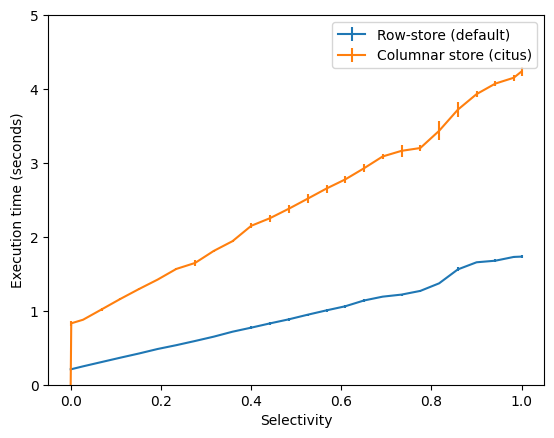

In [9]:
cache = Cache("~/db-experiments-cache/tpch-selectivity")

@cache.memoize()
def run_count_query(days):
    with conn2.cursor() as cur:
        cur.execute(count_query_template % days)
        return cur.fetchall()[0][0]

@cache.memoize()
def run_experiment_q1(days, store_type, run_id=0):
    # Returns query execution time in seconds.
    assert store_type in ["row", "columnar"]
    conn = conn1 if store_type == "row" else conn2
    print(f"days={days} {store_type} run {run_id}...")
    query = tpch_q1_template % d
    t0=time.time()
    with conn.cursor() as cur:
        cur.execute(query)
        cur.fetchall()
    return time.time()-t0


total_count = run_count_query(0)


sel_range=[]
row_mean=[]
row_std=[]
col_mean=[]
col_std=[]


for d in range(0,2700, 100):
    sel = run_count_query(d)/total_count
    sel_range.append(sel)
    #print(d, "sel=", sel)
    row_data = [run_experiment_q1(d, "row", run_id=run_id) for run_id in range(5)]
    row_mean.append(np.mean(row_data))
    row_std.append(np.std(row_data))

    col_data = [run_experiment_q1(d, "columnar", run_id=run_id) for run_id in range(5)]
    col_mean.append(np.mean(col_data))
    col_std.append(np.std(col_data))
    
    
    #print("columnar", [run_experiment_q1(d, "columnar", run_id=run_id) for run_id in range(5)])
plt.errorbar(sel_range, row_mean,yerr=row_std, label='Row-store (default)')    
plt.errorbar(sel_range, col_mean,yerr=col_std, label='Columnar store (citus)')    
plt.ylim(0,5)
plt.xlabel('Selectivity')
plt.ylabel('Execution time (seconds)')
plt.legend()